## Install dependencies

In [1]:
! pip install -U matplotlib pandas scikit-learn xgboost lightgbm umap-learn xopen orjson tqdm

## Prepare the notebook

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Calculate number of CPUs

In [2]:
import multiprocessing

In [3]:
workers = multiprocessing.cpu_count()
workers

4

# Import the libraries

In [4]:
from pathlib import Path
from typing import Union, Any
import gc

In [5]:
import joblib
from tqdm import tqdm

In [6]:
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd

In [8]:
from sklearn.model_selection import train_test_split

## File locations for training and validation / test data

In [9]:
path = Path('data')
DATA_DIR = path / 'www'
DATA_DIR.mkdir(exist_ok=True, parents=True)

In [ ]:
NODES_PATH = DATA_DIR / 'nodes.joblib'

In [13]:
! ls {DATA_DIR}

data  data.zip	models	nodes  nodes_all


# Download the data from the bucket

In [19]:
! gsutil -m cp gs://www21/nodes.joblib {NODES_PATH}

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnuma1
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 169 kB of archives.
After this operation, 593 kB of additional disk space will be used.
Get:1 http://europe-west4.gce.archive.ubuntu.com/ubuntu groovy/main amd64 unzip amd64 6.0-25ubuntu1 [169 kB]
Fetched 169 kB in 0s (2263 kB/s)33m

78Selecting previously unselected package unzip.
(Reading database ... 64342 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking unzip (6.0-25ubuntu1) ...
7Prog

In [16]:
! ls {DATA_DIR}

Copying gs://www21/data.zip...
| [1/1 files][162.8 MiB/162.8 MiB] 100% Done                                    
Operation completed over 1 objects/162.8 MiB.                                    


## Load training data

Load training data `X_train` and `y_train` and validation / test data `X_test` and `y_test` with `80% / 20%` ratio

In [24]:
X_train, X_test, y_train, y_test = joblib.load(NODE_PATH)

## Analyze data

In [25]:
from sklearn.manifold import TSNE
import umap

In [26]:
def show_distribution(frequencies:np.ndarray):
    """Plot distribution of labels"""
    labels = ['tag', 'ad']
    fig, ax = plt.subplots()
    plt.figure(figsize=(40, 40))
    im = ax.imshow(frequencies, cmap='viridis', interpolation='nearest')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels([])
    thresh = (frequencies.max() + frequencies.min()) / 2.0
    cmap_min, cmap_max = im.cmap(0), im.cmap(256)
    for i in range(2):
        for j in range(2):
            color = cmap_max if frequencies[i, j] < thresh else cmap_min
            freq_val = labels[i] if j == 0 else frequencies[i, j]
            text = ax.text(j, i, freq_val, ha='center', va='center', color=color)
    ax.set_title('Distribution of tag / ad labels')
    fig.tight_layout()
    plt.show()

#### Estimate the amount of data and labels

In [27]:
X_train.shape, y_train.shape

((92321, 654), (92321,))

In [28]:
X_test.shape, y_test.shape

((23081, 654), (23081,))

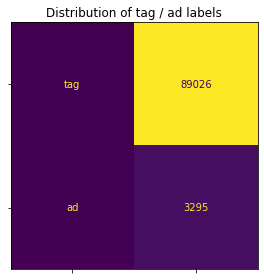

<Figure size 2880x2880 with 0 Axes>

In [29]:
unique_tr, counts_tr = np.unique(y_train, return_counts=True)
frequencies_tr = np.asarray((unique_tr, counts_tr)).T
frequencies_tr
show_distribution(frequencies_tr)

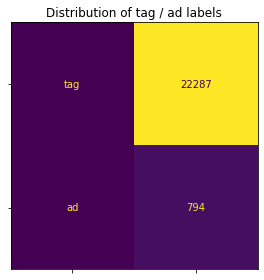

<Figure size 2880x2880 with 0 Axes>

In [30]:
unique_ts, counts_ts = np.unique(y_test, return_counts=True)
frequencies_ts = np.asarray((unique_ts, counts_ts)).T
show_distribution(frequencies_ts)

In [31]:
node_count = y_train.shape[0] + y_test.shape[0]
ad_count = counts_tr[1] + counts_ts[1]
print(f'{node_count=}, {ad_count=}, ads = {(ad_count / node_count) * 100:.2f}%')

node_count=115402, ad_count=4089, ads = 3.54%


#### Project nodes on `2D` plane with `UMAP` and `T-SNE`

Project node features on `2D` Euclidean plane preserving metrics (distances) between nodes using `UMAP` and `T-SNE` dimensionality reduction algorithms

In [32]:
def project_nodes(X:np.ndarray, y:np.ndarray, num_classes:int=2, 
                  model_cls:type=umap.UMAP, **kwargs) -> np.ndarray:
    """Project nodes on 2D plane"""
    return model_cls(n_components=num_classes, **kwargs).fit_transform(X, y=y)

#### Plot embeddings on `2D` plane 

In [33]:
def plot_nodes_1(z:np.ndarray, y:np.ndarray, colors:list, 
               model_cls:type=umap.UMAP,  num_classes:int=2, **kwargs):
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*z.T, s=20, c=y, cmap='viridis', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(num_classes))
    cbar.set_ticklabels(['tag', 'ad'])
    plt.title(f'Node features via {model_cls.__name__} using Labels');

In [34]:
def plot_nodes_2(z:np.ndarray, y:np.ndarray, colors:list,
               model_cls:type=umap.UMAP, num_classes:int=2, **kwargs):
    plt.figure(figsize=(8, 8))
    for i in range(num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.title(f'Node features via {model_cls.__name__} using Labels');
    plt.show()

In [35]:
colors = ['#ffc0cb', '#bada55']

In [36]:
embs_umap = project_nodes(X_test[:500], y_test[:500], model_cls=umap.UMAP)

In [37]:
embs_tsne = project_nodes(X_test[:500], y_test[:500], model_cls=TSNE, n_jobs=-1)

#### Plot projections

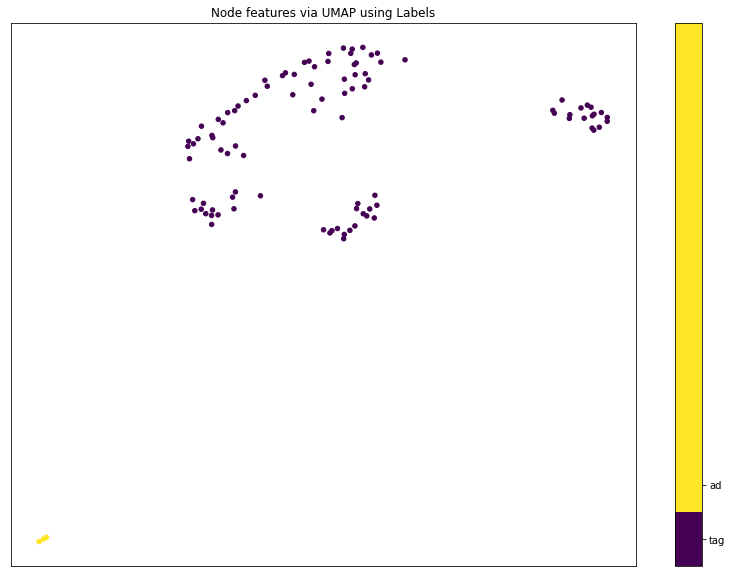

In [39]:
plot_nodes_1(embs_umap, y_test[:100], colors)

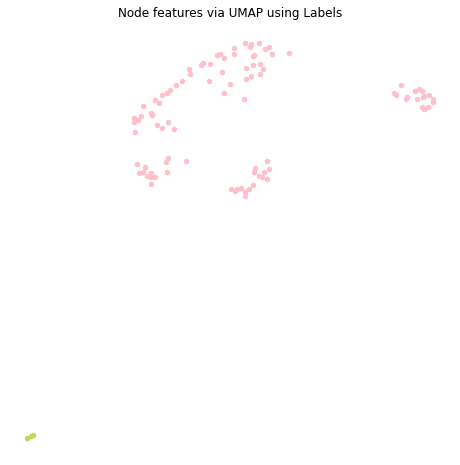

In [40]:
plot_nodes_2(embs_umap, y_test[:500], colors)

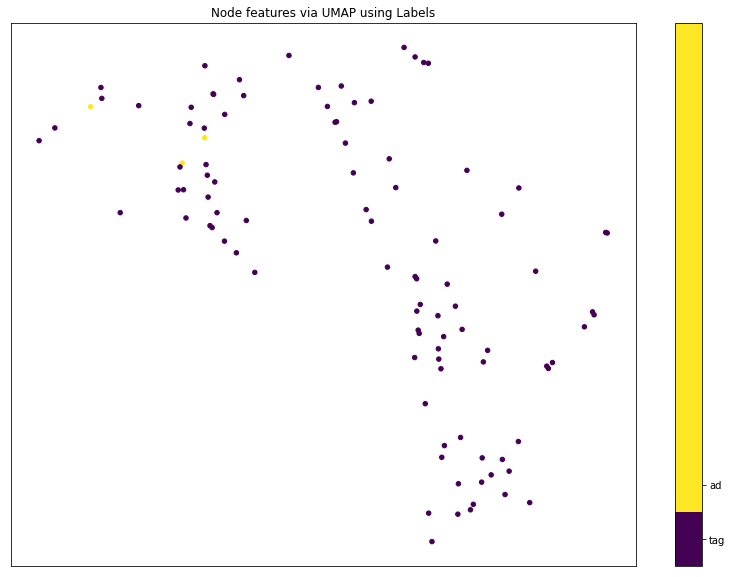

In [41]:
plot_nodes_1(embs_tsne, y_test[:500], colors)

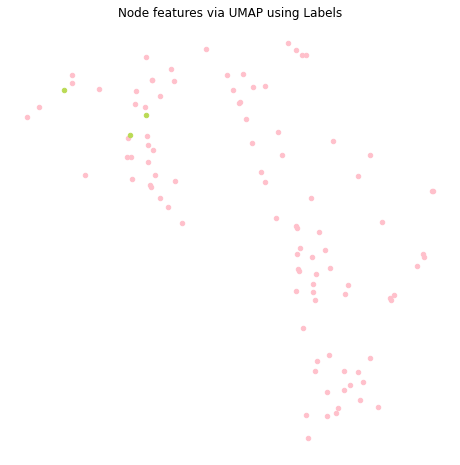

In [42]:
plot_nodes_2(embs_tsne, y_test[:500], colors)

## Train different tree based ensemble models on node features

Implement helper functions to analyze model's performance on validation / test set printing:
- Accuracy
- Precision
- Recall
- F1 score
and plotting the confusion matrix

In [43]:
from sklearn.base import ClassifierMixin, RegressorMixin
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, 
                             precision_recall_fscore_support)

In [44]:
def plot_confusion_matrix(cmx:np.ndarray):
    """Plot distribution of labels"""
    display_labels = ['tag', 'ad']
    disp = ConfusionMatrixDisplay(confusion_matrix=cmx,
                                  display_labels=display_labels)
    disp = disp.plot(include_values=True,
                     cmap='viridis', ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)
    disp.ax_.set_title('Confusion matrix')
    plt.show()

In [45]:
def estimate_model(
        y: np.ndarray,
        y_pred: np.ndarray) -> tuple:
    """
    Validate performane on predictions
    Args:
        y (np.ndarray): true labels
        y_pred (np.ndarray): predicted values

    Returns:
        val_acc (float): validation accuracy
        pr_rc_f1 (float): validation f1 score
        rep (dict): validation report dictionary
        cmx (np.ndarray): confusion matrix
    """
    val_acc = accuracy_score(y, y_pred, sample_weight=None)
    target_names = ['tag', 'ad']

    pr_rc_f1 = precision_recall_fscore_support(y, y_pred, beta=1.0,
                                               average='binary')
    rep = classification_report(y, y_pred, target_names=target_names,
                                zero_division=0)
    cmx = confusion_matrix(y, y_pred)

    return val_acc, pr_rc_f1, rep, cmx


def validate_model(
        md: ClassifierMixin,
        X: np.ndarray, y: np.ndarray) -> tuple:
    """
    validate model performance
    Args:
        md (Union[ClassifierMixin, RegressorMixin]): model to evaluate
        X (np.ndarray): evaluation data
        y (np.ndarray): evaluation labels

    Returns:
        val_acc (float): validation accuracy
        pr_rc_f1 (float): validation F1 score
        rep (dict): validation report dictionary
        cmx: (np.ndaray): confusion matrix
    """
    y_pred = md.predict(X)
    val_acc, pr_rc_f1, rep, cmx = estimate_model(y, y_pred)

    return val_acc, pr_rc_f1, rep, cmx

In [46]:
def validate_and_print(md, X, y):
    acc, prf1, rep, cmx = validate_model(md, X, y)
    tn, fp, fn, tp = cmx.ravel()
    pr, rc, f1_sc, _ = prf1
    print(f'accuracy: {acc:.4f}')
    print(f'precision: {pr:.4f}, recall: {rc:.4f}, f1_score: {f1_sc:.4f}')
    print(f'True positives: {tp}, false positives: {fp}, true negatives: {tn}, false negatives: {fn}')
    plot_confusion_matrix(cmx)

## Train Random Forest classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support, 
                             classification_report)

In [48]:
n_estimators = 50
max_depth = 50
min_samples_split = 8
max_samples = 0.6

######################
######################

random_state=0
n_jobs=workers
verbose=4

In [49]:
rf_params = dict(n_estimators=n_estimators, max_depth=max_depth, 
                 min_samples_split=min_samples_split,
                 max_samples=max_samples)

In [50]:
rfc = RandomForestClassifier(**rf_params, random_state=random_state, 
                             n_jobs=n_jobs, verbose=verbose)

In [51]:
rfc = rfc.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.8s


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.2s finished


model: Random Forest classifier n_estimators=50 X max_depth=50



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


accuracy: 0.9827
precision: 0.7770, recall: 0.6977, f1_score: 0.7352
True positives: 554, false positives: 159, true negatives: 22128, false negatives: 240


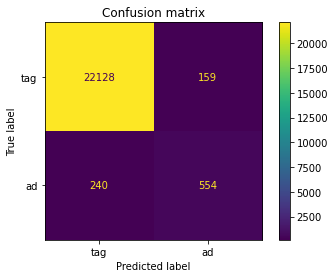

In [52]:
print(f'model: Random Forest classifier {n_estimators=} X {max_depth=}')
print()
validate_and_print(rfc, X_test, y_test)

#### Save Random Forest model

In [53]:
from joblib import dump, load

In [54]:
MODEL_PATH = www_data / 'models'
MODEL_PATH.mkdir(exist_ok=True)
RF_MODEL_PATH = MODEL_PATH / 'rf_model.joblib'
RF_MODEL_PATH

PosixPath('data/www/models/rf_model.joblib')

In [99]:
dump(rfc, RF_MODEL_PATH)

['data/www/models/rf_model.joblib']

#### De-serialize the model

In [103]:
rfc_ds = load(RF_MODEL_PATH)

model: Random Forest classifier n_estimators=50 X max_depth=50



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


accuracy: 0.9816
precision: 0.7562, recall: 0.6877, f1_score: 0.7203
True positives: 546, false positives: 176, true negatives: 22111, false negatives: 248


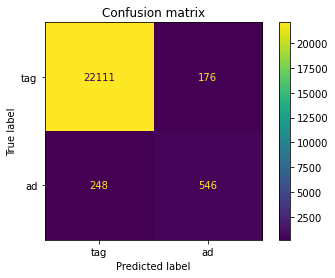

In [288]:
print(f'model: Random Forest classifier {n_estimators=} X {max_depth=}')
print()
validate_and_print(rfc_ds, X_test, y_test)

In [ ]:
del rfc
del rfc_ds

In [105]:
gc.collect()

4116

## Train GXBoost classifier

In [55]:
import xgboost as xgb

In [59]:
n_estimators = 512
max_depth = 8
max_samples = 0.4
tree_method = 'exact'##'approx'
learning_rate = 0.1

######################
######################

random_state=0
n_jobs=workers
verbose=3

In [60]:
xgc = xgb.XGBClassifier(n_estimators=n_estimators, use_label_encoder=False, tree_method=tree_method,
                        max_depth=max_depth, min_samples_split=min_samples_split,
                        learning_rate=learning_rate, verbosity=verbose, n_jobs=n_jobs, random_state=random_state)

In [66]:
xgc.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric = ['auc', 'error'], verbose=True)

[22:03:45] WARNING: ../src/learner.cc:541: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.91527	validation_0-error:0.02612
[22:03:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.91886	validation_0-error:0.02530
[22:03:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.93990	validation_0-error:0.02400
[22:03:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.94021	validation_

[22:04:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[47]	validation_0-auc:0.99161	validation_0-error:0.01633
[22:04:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[48]	validation_0-auc:0.99164	validation_0-error:0.01651
[22:04:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[49]	validation_0-auc:0.99181	validation_0-error:0.01603
[22:04:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[50]	validation_0-auc:0.99181	validation_0-error:0.01607
[22:04:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=8
[51]	validation_0-auc:0.99183	validation_0-error:0.01607
[22:04:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
[52]	validation_0-auc:0.99189	valida

[22:05:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=8
[96]	validation_0-auc:0.99253	validation_0-error:0.01547
[22:05:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[97]	validation_0-auc:0.99252	validation_0-error:0.01547
[22:05:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[98]	validation_0-auc:0.99254	validation_0-error:0.01547
[22:05:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[99]	validation_0-auc:0.99254	validation_0-error:0.01547
[22:05:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[100]	validation_0-auc:0.99252	validation_0-error:0.01551
[22:05:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=8
[101]	validation_0-auc:0.99249	val

[22:06:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[144]	validation_0-auc:0.99242	validation_0-error:0.01551
[22:06:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=8
[145]	validation_0-auc:0.99243	validation_0-error:0.01555
[22:06:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[146]	validation_0-auc:0.99243	validation_0-error:0.01555
[22:06:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[147]	validation_0-auc:0.99245	validation_0-error:0.01555
[22:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=8
[148]	validation_0-auc:0.99246	validation_0-error:0.01555
[22:06:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[149]	validation_0-auc:0.99246	v

[22:07:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=8
[192]	validation_0-auc:0.99240	validation_0-error:0.01547
[22:07:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=8
[193]	validation_0-auc:0.99240	validation_0-error:0.01547
[22:07:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[194]	validation_0-auc:0.99240	validation_0-error:0.01551
[22:07:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=8
[195]	validation_0-auc:0.99238	validation_0-error:0.01542
[22:07:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=8
[196]	validation_0-auc:0.99243	validation_0-error:0.01542
[22:07:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[197]	validation_0-auc:0.99242

[22:08:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[240]	validation_0-auc:0.99237	validation_0-error:0.01586
[22:08:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[241]	validation_0-auc:0.99234	validation_0-error:0.01586
[22:08:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=8
[242]	validation_0-auc:0.99233	validation_0-error:0.01594
[22:08:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=8
[243]	validation_0-auc:0.99233	validation_0-error:0.01581
[22:08:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=8
[244]	validation_0-auc:0.99233	validation_0-error:0.01577
[22:08:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[245]	validation_0-auc:0.99234

[22:09:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=8
[288]	validation_0-auc:0.99224	validation_0-error:0.01616
[22:09:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[289]	validation_0-auc:0.99224	validation_0-error:0.01620
[22:09:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[290]	validation_0-auc:0.99223	validation_0-error:0.01620
[22:09:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[291]	validation_0-auc:0.99223	validation_0-error:0.01625
[22:09:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[292]	validation_0-auc:0.99223	validation_0-error:0.01625
[22:09:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[293]	validation_0-auc:0.99223	v

[22:10:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[336]	validation_0-auc:0.99204	validation_0-error:0.01629
[22:10:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[337]	validation_0-auc:0.99203	validation_0-error:0.01625
[22:10:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[338]	validation_0-auc:0.99202	validation_0-error:0.01625
[22:10:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=8
[339]	validation_0-auc:0.99202	validation_0-error:0.01620
[22:10:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[340]	validation_0-auc:0.99201	validation_0-error:0.01620
[22:10:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[341]	validation_0-auc:0.99201	v

[22:11:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[384]	validation_0-auc:0.99195	validation_0-error:0.01616
[22:11:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[385]	validation_0-auc:0.99194	validation_0-error:0.01612
[22:11:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[386]	validation_0-auc:0.99193	validation_0-error:0.01612
[22:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[387]	validation_0-auc:0.99194	validation_0-error:0.01607
[22:11:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[388]	validation_0-auc:0.99194	validation_0-error:0.01603
[22:11:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[389]	validation_0-auc:0.99194	v

[22:12:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[432]	validation_0-auc:0.99182	validation_0-error:0.01625
[22:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[433]	validation_0-auc:0.99182	validation_0-error:0.01625
[22:12:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[434]	validation_0-auc:0.99182	validation_0-error:0.01625
[22:12:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[435]	validation_0-auc:0.99182	validation_0-error:0.01625
[22:12:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[436]	validation_0-auc:0.99181	validation_0-error:0.01625
[22:12:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
[437]	validation_0-auc:0.99182	v

[22:13:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[480]	validation_0-auc:0.99154	validation_0-error:0.01620
[22:13:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=8
[481]	validation_0-auc:0.99153	validation_0-error:0.01616
[22:13:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=8
[482]	validation_0-auc:0.99154	validation_0-error:0.01616
[22:13:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[483]	validation_0-auc:0.99154	validation_0-error:0.01616
[22:13:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=8
[484]	validation_0-auc:0.99154	validation_0-error:0.01616
[22:13:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[485]	validation_0-auc:0.99152	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, min_samples_split=8, missing=nan,
              monotone_constraints='()', n_estimators=512, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=3)

In [72]:
evals_result = xgc.evals_result()
evals_result

{'validation_0': OrderedDict([('auc',
               [0.915273,
                0.91886,
                0.9399,
                0.940206,
                0.95119,
                0.956539,
                0.970561,
                0.974481,
                0.978011,
                0.979293,
                0.981181,
                0.983617,
                0.984986,
                0.985192,
                0.985861,
                0.986188,
                0.98659,
                0.986829,
                0.987235,
                0.987949,
                0.98819,
                0.988583,
                0.988912,
                0.989118,
                0.989286,
                0.989852,
                0.990145,
                0.990335,
                0.990431,
                0.990625,
                0.99066,
                0.990764,
                0.990763,
                0.990854,
                0.990892,
                0.990938,
                0.991115,
       

model: XGBoost classifier n_estimators=512 X max_depth=8

accuracy: 0.9835
precision: 0.7782, recall: 0.7292, f1_score: 0.7529
True positives: 579, false positives: 165, true negatives: 22122, false negatives: 215


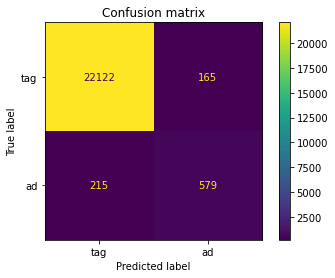

In [64]:
print(f'model: XGBoost classifier {n_estimators=} X {max_depth=}')
print()
validate_and_print(xgc, X_test, y_test)

## Serialize the model

In [113]:
MODEL_PATH = www_data / 'models'
MODEL_PATH.mkdir(exist_ok=True)
XGC_MODEL_PATH = MODEL_PATH / 'xgc_model.joblib'
XGC_MODEL_PATH

PosixPath('data/www/models/xgc_model.joblib')

In [115]:
dump(xgc, XGC_MODEL_PATH)

['data/www/models/xgc_model.joblib']

## Load the model

In [68]:
xgc_ds = load(XGC_MODEL_PATH)

NameError: name 'XGC_MODEL_PATH' is not defined

In [146]:
validate_and_print(xgc_ds, X_test, y_test)

Uniques labels = (array([0, 1]), array([22287,   794])) predictions (array([0, 1]), array([22340,   741]))
accuracy: 0.9793
precision: 0.7139, recall: 0.6662, f1_score: 0.6893
[[22075   212]
 [  265   529]]
tp=529, fp=212, tn=22075, fn=265
              precision    recall  f1-score   support

         tag       0.99      0.99      0.99     22287
          ad       0.71      0.67      0.69       794

    accuracy                           0.98     23081
   macro avg       0.85      0.83      0.84     23081
weighted avg       0.98      0.98      0.98     23081



## Grid search for XGBoost classifier (optional)

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [70]:
n_estimators_search = [50, 126, 158, 200]
max_depth_search = [8, 16, 26, 56]
learning_rate_search = [0.001, 0.01, 0.1, 0.2, 0.3, 1.0]

In [71]:
param_grid = dict(max_depth=max_depth_search, 
                  n_estimators=n_estimators_search,
                  learning_rate=learning_rate_search)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [72]:
xgc_srch = xgb.XGBClassifier(use_label_encoder=False, tree_method=tree_method, 
                        verbosity=1, random_state=random_state)

#### Data sample

In [120]:
(X_bg_sp, X_sm_sp, y_pg_sp, y_sm_sp) = train_test_split(X_train, y_train, 
                                                        test_size=0.01, random_state=2020)

In [121]:
X_sm_sp.shape, y_sm_sp.shape

((924, 636), (924,))

#### Search parameters

In [122]:
grid_search = GridSearchCV(xgc_srch, param_grid, n_jobs=n_jobs, 
                           cv=kfold, verbose=3)

In [ ]:
grid_result = grid_search.fit(X_sm_sp, y_sm_sp)

In [170]:
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missin...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                              

In [171]:
best_params = grid_result.best_params_
best_params

{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 50}

In [172]:
best_xgc = grid_result.best_estimator_
xgb_params = best_xgc.get_params()
best_xgc, xgb_params

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.3, max_delta_step=0, max_depth=8,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=50, n_jobs=64, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=1),
 {'objective': 'binary:logistic',
  'use_label_encoder': False,
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 0,
  'gpu_id': -1,
  'importance_type': 'gain',
  'interaction_constraints': '',
  'learning_rate': 0.3,
  'max_delta_step': 0,
  'max_depth': 8,
  'min_child_weight': 1,
  'missing': n

In [68]:
gc.collect()

300081

## Train LightGBM classifierm

In [73]:
gc.collect()

80849

In [74]:
import lightgbm as lgb

In [75]:
n_estimators = 2048 * 2
max_depth = 7
num_leaves=min(2**max_depth, 80)
max_samples = 0.4

## GBM specific ##
objective = 'binary'
num_leaves = 128
learning_rate=0.1
min_data_in_leaf = 800

######################
######################

random_state=0
n_jobs=-1
verbose=100

######################
######################

num_round = 10

In [76]:
gb_essent = dict(n_estimators=n_estimators, max_depth=max_depth, 
                 objective=objective,
                 num_leaves=num_leaves,
                 min_data_in_leaf=min_data_in_leaf,
                 learning_rate=learning_rate)
                 
gb_params_add = dict(random_state=random_state,
                     n_jobs=n_jobs,
                     verbose=verbose)

In [77]:
gb_additional = dict(#metric='auc',
                     objective='binary',
                     num_leaves=num_leaves,
                     learning_rate=0.05,
                     min_data_in_leaf=min_data_in_leaf,
                     is_unbalance=True,
                     boosting_type='gbdt',
                     num_boost_round=12000,
                     early_stopping_rounds=1000,
                     bagging_freq=16,
                     bagging_fraction=0.76,
                     min_gain_to_split=0.24,
                     silent=False,
                    )

In [78]:
gb_params = {**gb_essent, **gb_additional}

In [80]:
lgc = lgb.LGBMClassifier(**gb_params, random_state=random_state, n_jobs=n_jobs, verbose=verbose)

In [82]:
lgc = lgc.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=4)

/home/levan/anaconda3/envs/graphs/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/levan/anaconda3/envs/graphs/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=1000, early_stopping_rounds=1000 will be ignored. Current value: early_stopping_round=1000
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] min_gain_to_split is set=0.24, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] num_iterations is set=12000, num_boost_round=12000 will be ignored. Current value: num_iterations=12000
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[44]	valid_0's binary_logloss: 0.171825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[96]	valid_0's binary_logloss: 0.174064
[LightGBM] [Debug] Re-bagging, using 70030 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[100]	valid_0's binary_logloss: 0.17233

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 7
[148]	valid_0's binary_logloss: 0.159413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[152]	valid_0's binary_logloss: 0.158638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and max_depth = 7
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 7
[204]	valid_0's binary_logloss: 0.145055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 7
[208]	valid_0's binary_logloss: 0.14418
[LightGBM] [Debug] Re-bagging, using 70050 data to trai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[260]	valid_0's binary_logloss: 0.12963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[264]	valid_0's binary_logloss: 0.12941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[320]	valid_0's binary_logloss: 0.120554
[LightGBM] [Debug] Re-bagging, using 70081 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[324]	valid_0's binary_logloss: 0.119846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth =

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[380]	valid_0's binary_logloss: 0.114124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[384]	valid_0's binary_logloss: 0.113626
[LightGBM] [Debug] Re-bagging, using 70223 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth =

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[440]	valid_0's binary_logloss: 0.106092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[500]	valid_0's binary_logloss: 0.101382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[560]	valid_0's binary_logloss: 0.0995855
[LightGBM] [Debug] Re-bagging, using 70090 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[616]	valid_0's binary_logloss: 0.0964521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and max_depth = 7
[672]	valid_0's binary_logloss: 0.094311
[LightGBM] [Debug] Re-bagging, using 70218 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[676]	valid_0's binary_logloss: 0.0937

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[724]	valid_0's binary_logloss: 0.0913011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[728]	valid_0's binary_logloss: 0.0911239
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[784]	valid_0's binary_logloss: 0.0903632
[LightGBM] [Debug] Re-bagging, using 70323 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[840]	valid_0's binary_logloss: 0.0884617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[844]	valid_0's binary_logloss: 0.0884156
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[900]	valid_0's binary_logloss: 0.086688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 47 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[956]	valid_0's binary_logloss: 0.0854936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[960]	valid_0's binary_logloss: 0.0853158
[LightGBM] [Debug] Re-bagging, using 70268 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[1012]	valid_0's binary_logloss: 0.0847964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[1072]	valid_0's binary_logloss: 0.0833293
[LightGBM] [Debug] Re-bagging, using 70004 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[1124]	valid_0's binary_logloss: 0.0837033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[1180]	valid_0's binary_logloss: 0.0830452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[1184]	valid_0's binary_logloss: 0.0830332
[LightGBM] [Debug] Re-bagging, using 70102 data to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 51 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[1236]	valid_0's binary_logloss: 0.0814317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[1240]	valid_0's binary_logloss: 0.0813206
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[1292]	valid_0's binary_logloss: 0.0808176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and max_depth = 7
[1296]	valid_0's binary_logloss: 0.0807277
[LightGBM] [Debug] Re-bagging, using 70129 data to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[1348]	valid_0's binary_logloss: 0.0805512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 7
[1352]	valid_0's binary_logloss: 0.0805859
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[1404]	valid_0's binary_logloss: 0.0792152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[1408]	valid_0's binary_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[1460]	valid_0's binary_logloss: 0.0789611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[1464]	valid_0's binary_logloss: 0.0788727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positi

[1512]	valid_0's binary_logloss: 0.0782088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 47 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 47 and max_depth = 7
[1516]	valid_0's binary_logloss: 0.0780709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[1572]	valid_0's binary_logloss: 0.0779622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[1628]	valid_0's binary_logloss: 0.0770845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[1684]	valid_0's binary_logloss: 0.0765369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 7
[1744]	valid_0's binary_logloss: 0.0771334
[LightGBM] [Debug] Re-bagging, using 70233 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 48 and max_depth = 7
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[1796]	valid_0's binary_logloss: 0.0758916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[1852]	valid_0's binary_logloss: 0.0757664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[1908]	valid_0's binary_logloss: 0.0755463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[1964]	valid_0's binary_logloss: 0.0751703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[1968]	valid_0's binary_logloss: 0.0751451
[LightGBM] [Debug] Re-bagging, using 70290 data to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[2016]	valid_0's binary_logloss: 0.0755229
[LightGBM] [Debug] Re-bagging, using 70176 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[2020]	valid_0's binary_logloss: 0.0755187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 54 and max_dep

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[2072]	valid_0's binary_logloss: 0.0748229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[2076]	valid_0's binary_logloss: 0.0746687
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[2128]	valid_0's binary_logloss: 0.073973
[LightGBM] [Debug] Re-bagging, using 70226 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[2184]	valid_0's binary_logloss: 0.0743587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[2240]	valid_0's binary_logloss: 0.0745846
[LightGBM] [Debug] Re-bagging, using 70094 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[2244]	valid_0's binary_logloss: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[2300]	valid_0's binary_logloss: 0.0745078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 48 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[2356]	valid_0's binary_logloss: 0.0738357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 7
[2412]	valid_0's binary_logloss: 0.0736939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and max_depth = 7
[2416]	valid_0's binary_logloss: 0.0736091
[LightGBM] [Debug] Re-bagging, using 70341 data to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[2468]	valid_0's binary_logloss: 0.0739524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[2520]	valid_0's binary_logloss: 0.0746086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[2524]	valid_0's binary_logloss: 0.0746343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[2576]	valid_0's binary_logloss: 0.0744376
[LightGBM] [Debug] Re-bagging, using 70173 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[2580]	valid_0's binary_logloss: 0.0743526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_dep

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 51 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[2636]	valid_0's binary_logloss: 0.074294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 47 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[2692]	valid_0's binary_logloss: 0.0738947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[2748]	valid_0's binary_logloss: 0.0737869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[2804]	valid_0's binary_logloss: 0.0736588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[2808]	valid_0's binary_logloss: 0.0736857
[LightGBM] [Warning] No further splits with positi

[2860]	valid_0's binary_logloss: 0.07376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[2864]	valid_0's binary_logloss: 0.0737884
[LightGBM] [Debug] Re-bagging, using 70282 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth

[2916]	valid_0's binary_logloss: 0.0739959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[2920]	valid_0's binary_logloss: 0.0740568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[2972]	valid_0's binary_logloss: 0.0736927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[2976]	valid_0's binary_logloss: 0.0737157
[LightGBM] [Debug] Re-bagging, using 70336 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_dep

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[3028]	valid_0's binary_logloss: 0.0733265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[3032]	valid_0's binary_logloss: 0.0733711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[3084]	valid_0's binary_logloss: 0.0734476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[3088]	valid_0's binary_logloss: 0.0734307
[LightGBM] [Debug] Re-bagging, using 70156 data to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 48 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[3140]	valid_0's binary_logloss: 0.0732092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 45 and max_depth = 7
[3196]	valid_0's binary_logloss: 0.073279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[3200]	valid_0's binary_logloss: 0.073255
[LightGBM] [Debug] Re-bagging, using 70117 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth

[3248]	valid_0's binary_logloss: 0.0733483
[LightGBM] [Debug] Re-bagging, using 70072 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[3252]	valid_0's binary_logloss: 0.0733271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_dep

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[3304]	valid_0's binary_logloss: 0.0734878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[3356]	valid_0's binary_logloss: 0.0734601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[3360]	valid_0's binary_logloss: 0.0733918
[LightGBM] [Debug] Re-bagging, using 70306 data to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[3412]	valid_0's binary_logloss: 0.0733888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[3464]	valid_0's binary_logloss: 0.073737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[3468]	valid_0's binary_logloss: 0.073716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[3520]	valid_0's binary_logloss: 0.0738571
[LightGBM] [Debug] Re-bagging, using 70375 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and max_depth = 7
[3524]	valid_0's binary_logloss: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 47 and max_depth = 7
[3572]	valid_0's binary_logloss: 0.0736135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[3576]	valid_0's binary_logloss: 0.0736575
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[3628]	valid_0's binary_logloss: 0.0734447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 50 and max_depth = 7
[3684]	valid_0's binary_logloss: 0.07346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 49 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[3688]	valid_0's binary_logloss: 0.0734258
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[3744]	valid_0's binary_logloss: 0.073635
[LightGBM] [Debug] Re-bagging, using 70299 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 43 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 44 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 46 and max_depth = 7
[3796]	valid_0's binary_logloss: 0.0734699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[3852]	valid_0's binary_logloss: 0.0736164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[3904]	valid_0's binary_logloss: 0.0735108
[LightGBM] [Debug] Re-bagging, using 69967 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 34 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further spli

[3956]	valid_0's binary_logloss: 0.073887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[3960]	valid_0's binary_logloss: 0.0739055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[4016]	valid_0's binary_logloss: 0.0738802
[LightGBM] [Debug] Re-bagging, using 70077 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[4020]	valid_0's binary_logloss: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[4076]	valid_0's binary_logloss: 0.0739541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[4080]	valid_0's binary_logloss: 0.0739161
[LightGBM] [Debug] Re-bagging, using 70185 data to

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 53 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 58 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 42 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 55 and max_depth = 7
[4132]	valid_0's binary_logloss: 0.0735422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 57 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 54 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[4184]	valid_0's binary_logloss: 0.074209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 39 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[4188]	valid_0's binary_logloss: 0.0743284
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 7
[4240]	valid_0's binary_logloss: 0.0740449
[LightGBM] [Debug] Re-bagging, using 70291 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 35 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[4244]	valid_0's binary_logloss: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 32 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 37 and max_depth = 7
[4296]	valid_0's binary_logloss: 0.0741266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 33 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[4300]	valid_0's binary_logloss: 0.0740484
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[4348]	valid_0's binary_logloss: 0.0745222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and max_depth = 7
[4352]	valid_0's binary_logloss: 0.0745338
[LightGBM] [Debug] Re-bagging, using 70129 data to

model: LightGBM classifier n_estimators=4096 X max_depth=7

accuracy: 0.9759
precision: 0.6042, recall: 0.8690, f1_score: 0.7128
True positives: 690, false positives: 452, true negatives: 21835, false negatives: 104


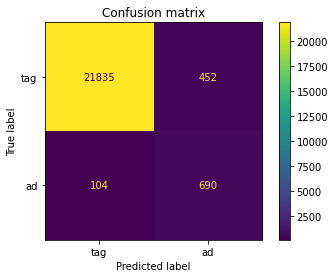

In [83]:
print(f'model: LightGBM classifier {n_estimators=} X {max_depth=}')
print()
validate_and_print(lgc, X_test, y_test)

## Serialize the model

In [137]:
MODEL_PATH = www_data / 'models'
MODEL_PATH.mkdir(exist_ok=True)
LGC_MODEL_PATH = MODEL_PATH / 'lgc_model.joblib'
LGC_MODEL_PATH

PosixPath('data/www/models/lgc_model.joblib')

In [138]:
dump(lgc, LGC_MODEL_PATH)

['data/www/models/lgc_model.joblib']

## Load the model

In [143]:
lgc_ds = load(LGC_MODEL_PATH)

In [144]:
validate_and_print(lgc_ds, X_test, y_test)

Uniques labels = (array([0, 1]), array([22287,   794])) predictions (array([0, 1]), array([21771,  1310]))
accuracy: 0.9694
precision: 0.5336, recall: 0.8804, f1_score: 0.6644
[[21676   611]
 [   95   699]]
tp=699, fp=611, tn=21676, fn=95
              precision    recall  f1-score   support

         tag       1.00      0.97      0.98     22287
          ad       0.53      0.88      0.66       794

    accuracy                           0.97     23081
   macro avg       0.76      0.93      0.82     23081
weighted avg       0.98      0.97      0.97     23081

